Display Data

In [4]:
import pandas as pd
import numpy as np

# =========================================================
# 1. BACA DATA
# =========================================================

# Ganti path ini kalau file kamu ada di folder lain
file_path = "PL_asset_classes.xlsx"

df = pd.read_excel(file_path)

# Pastikan kolom Date terbaca sebagai datetime (kalau ada)
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])

# Jika di file lama kolomnya masih bernama RD_Saham, rename ke Saham_THT
if "RD_Saham" in df.columns and "Saham_THT" not in df.columns:
    df = df.rename(columns={"RD_Saham": "Saham_THT"})

# Tiga kelas aset yang akan dihitung
asset_cols = ["FI_THT", "RD_THT", "Saham_THT"]

# Cek apakah semua kolom ada
missing = [c for c in asset_cols if c not in df.columns]
if missing:
    raise ValueError(f"Kolom berikut tidak ditemukan di file Excel: {missing}")

# =========================================================
# 2. FUNGSI MENGHITUNG HISTORICAL VaR & ES PER KELAS ASET
# =========================================================

results = {}

for col in asset_cols:
    series = df[col].dropna()  # buang NaN
    n = len(series)
    if n < 5:
        raise ValueError(f"Data untuk {col} terlalu sedikit (hanya {n} observasi).")

    mu = series.mean()
    sigma = series.std(ddof=1)

    # Level confidence
    alpha_95 = 0.95
    alpha_99 = 0.99

    # ============================
    # Historical VaR (berbasis return PL)
    # ============================
    # Di sini PL (misal -0.05 = -5%) → quantile kiri = return terburuk
    q05 = series.quantile(1 - alpha_95)  # 5% kiri
    q01 = series.quantile(1 - alpha_99)  # 1% kiri

    # VaR sebagai angka positif (kerugian)
    var95 = -q05
    var99 = -q01

    # ============================
    # Expected Shortfall (ES) - berbasis loss
    # ============================
    # Definisikan loss = -return (jadi kalau return -5%, loss +5%)
    losses = -series

    # Kuantil loss di kanan (95% & 99%)
    loss_q95 = np.quantile(losses, alpha_95)
    loss_q99 = np.quantile(losses, alpha_99)

    # ES = rata-rata loss di atas threshold VaR (loss_q)
    es95 = losses[losses >= loss_q95].mean()
    es99 = losses[losses >= loss_q99].mean()

    results[col] = {
        "n_obs": n,
        "mean_return": mu,
        "stdev_return": sigma,
        "hist_VaR95_pct": var95,          # dalam satuan desimal (mis. 0.0563 = 5.63%)
        "hist_VaR99_pct": var99,
        "hist_ES95_loss_pct": es95,       # ES dalam loss (positif)
        "hist_ES99_loss_pct": es99,
    }

# =========================================================
# 3. HITUNG EL, UL, TAIL LOSS
# =========================================================

ul_results = {}

for col, res in results.items():
    EL = -res["mean_return"]            # Expected Loss = -mean (positif kalau rata2 rugi)
    VaR95 = res["hist_VaR95_pct"]
    VaR99 = res["hist_VaR99_pct"]
    ES95 = res["hist_ES95_loss_pct"]
    ES99 = res["hist_ES99_loss_pct"]

    ul_results[col] = {
        "EL_pct": EL,
        "UL95_pct": VaR95 - EL,         # UL95 = VaR95 - EL
        "UL99_pct": VaR99 - EL,         # UL99 = VaR99 - EL
        "Tail95_pct": ES95 - VaR95,     # Tail gap di atas VaR95
        "Tail99_pct": ES99 - VaR99,     # Tail gap di atas VaR99
    }

# =========================================================
# 4. SUSUN TABEL DALAM %
# =========================================================

table = {}
for col in asset_cols:
    r = results[col]
    u = ul_results[col]
    table[col] = {
        "n_obs": r["n_obs"],
        "mean_%": r["mean_return"] * 100,
        "stdev_%": r["stdev_return"] * 100,
        "VaR95_%": r["hist_VaR95_pct"] * 100,
        "VaR99_%": r["hist_VaR99_pct"] * 100,
        "ES95_%": r["hist_ES95_loss_pct"] * 100,
        "ES99_%": r["hist_ES99_loss_pct"] * 100,
        "EL_%": u["EL_pct"] * 100,
        "UL95_%": u["UL95_pct"] * 100,
        "UL99_%": u["UL99_pct"] * 100,
        "Tail95_gap_%": u["Tail95_pct"] * 100,
        "Tail99_gap_%": u["Tail99_pct"] * 100,
    }

summary_df = pd.DataFrame(table).T.round(2)

print("\n=== RINGKASAN VaR / EL / UL / TAIL LOSS (dalam % per bulan) ===")
print(summary_df)


=== RINGKASAN VaR / EL / UL / TAIL LOSS (dalam % per bulan) ===
           n_obs  mean_%  stdev_%  VaR95_%  VaR99_%  ES95_%  ES99_%   EL_%  \
FI_THT      47.0   -1.24     2.96     5.63    10.09    8.52   12.87   1.24   
RD_THT      47.0   -4.63     4.16     9.66     9.84    9.80    9.88   4.63   
Saham_THT   35.0  -18.84    12.81    29.74    31.84   31.72   32.09  18.84   

           UL95_%  UL99_%  Tail95_gap_%  Tail99_gap_%  
FI_THT       4.40    8.86          2.89          2.78  
RD_THT       5.03    5.21          0.15          0.04  
Saham_THT   10.90   13.00          1.98          0.25  


Portfolio

In [6]:
V_FI = 10_000_000   # contoh: 10 juta
V_RD = 3_000_000    # contoh: 3 juta
V_Saham = 2_000_000 # contoh: 2 juta

market_values = {
    "FI_THT": V_FI,
    "RD_THT": V_RD,
    "Saham_THT": V_Saham,
}

amount_rows = {}

for col in asset_cols:
    V = market_values[col]
    u = ul_results[col]
    r = results[col]
    amount_rows[col] = {
        "EL_Rp": u["EL_pct"] * V,
        "VaR95_Rp": r["hist_VaR95_pct"] * V,
        "VaR99_Rp": r["hist_VaR99_pct"] * V,
        "UL95_Rp": u["UL95_pct"] * V,
        "UL99_Rp": u["UL99_pct"] * V,
    }

amount_df = pd.DataFrame(amount_rows).T

print("\n=== EL / VaR / UL dalam Rupiah ===")
print(amount_df)


=== EL / VaR / UL dalam Rupiah ===
                   EL_Rp       VaR95_Rp      VaR99_Rp        UL95_Rp  \
FI_THT     123568.602852  563151.714870  1.009252e+06  439583.112018   
RD_THT     138888.970040  289740.000000  2.952960e+05  150851.029960   
Saham_THT  376808.920603  594824.422406  6.368161e+05  218015.501803   

                 UL99_Rp  
FI_THT     885682.898913  
RD_THT     156407.029960  
Saham_THT  260007.141461  


Graphs


=== FI_THT ===
Mean       : -1.2357%
Stdev      : 2.9551%
VaR95 (ret): -5.6315%
VaR99 (ret): -10.0925%


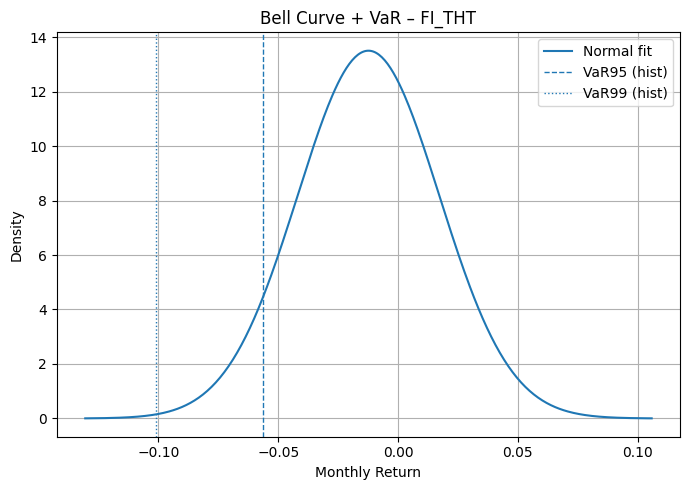


=== RD_THT ===
Mean       : -4.6296%
Stdev      : 4.1576%
VaR95 (ret): -9.6580%
VaR99 (ret): -9.8432%


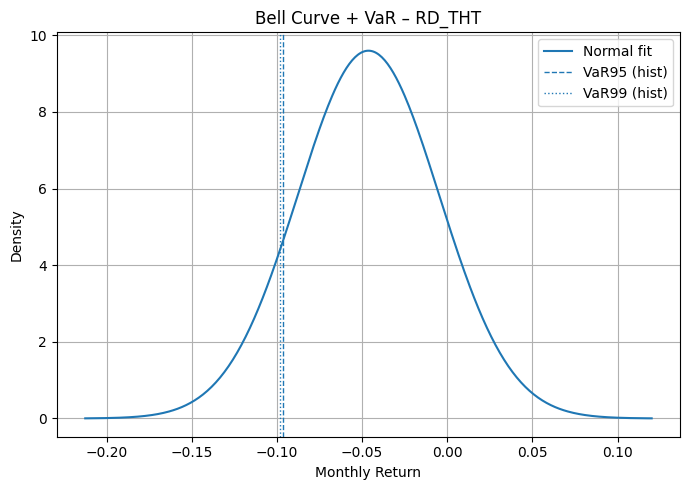


=== Saham_THT ===
Mean       : -18.8404%
Stdev      : 12.8077%
VaR95 (ret): -29.7412%
VaR99 (ret): -31.8408%


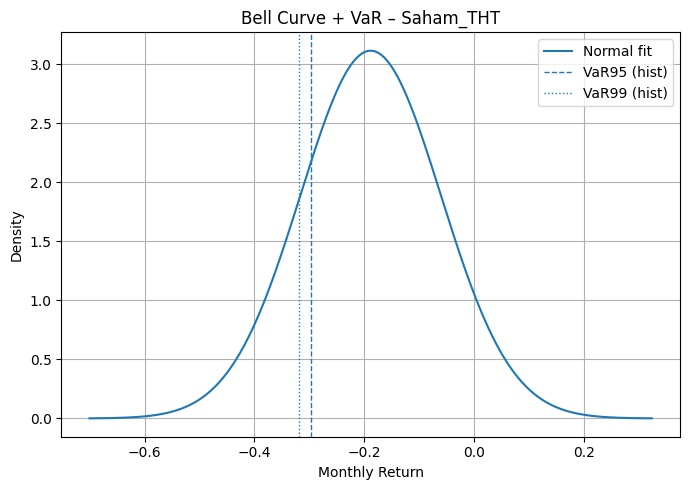

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# =========================================================
# 1. Load data
# =========================================================

file_path = "PL_asset_classes.xlsx"
df = pd.read_excel(file_path)

asset_cols = ["FI_THT", "RD_THT", "Saham_THT"]

# =========================================================
# 2. Plot bell curve + garis VaR untuk tiap asset class
# =========================================================

for col in asset_cols:
    series = df[col].dropna()
    mu = series.mean()
    sigma = series.std(ddof=1)

    # --------- Historical VaR (berbasis data) ----------
    alpha_95 = 0.95
    alpha_99 = 0.99

    # quantile kiri (return terburuk) → q05, q01 (negatif untuk loss)
    q05 = series.quantile(1 - alpha_95)   # 5% quantile
    q01 = series.quantile(1 - alpha_99)   # 1% quantile

    print(f"\n=== {col} ===")
    print(f"Mean       : {mu:.4%}")
    print(f"Stdev      : {sigma:.4%}")
    print(f"VaR95 (ret): {q05:.4%}")   # posisi di sumbu x
    print(f"VaR99 (ret): {q01:.4%}")

    # --------- Normal fit (bell curve) ----------
    x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 400)
    y = norm.pdf(x, mu, sigma)

    plt.figure(figsize=(7, 5))
    plt.plot(x, y, label="Normal fit")

    # Garis vertikal VaR di posisi return (negatif di kiri)
    plt.axvline(q05, linestyle="--", linewidth=1, label="VaR95 (hist)")
    plt.axvline(q01, linestyle=":",  linewidth=1, label="VaR99 (hist)")

    plt.title(f"Bell Curve + VaR – {col}")
    plt.xlabel("Monthly Return")
    plt.ylabel("Density")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

Komparasi


=== FI_THT ===
n         : 47
Mean      : -1.2357%
Stdev     : 2.9551%
VaR95(ret): -5.6315%
VaR99(ret): -10.0925%


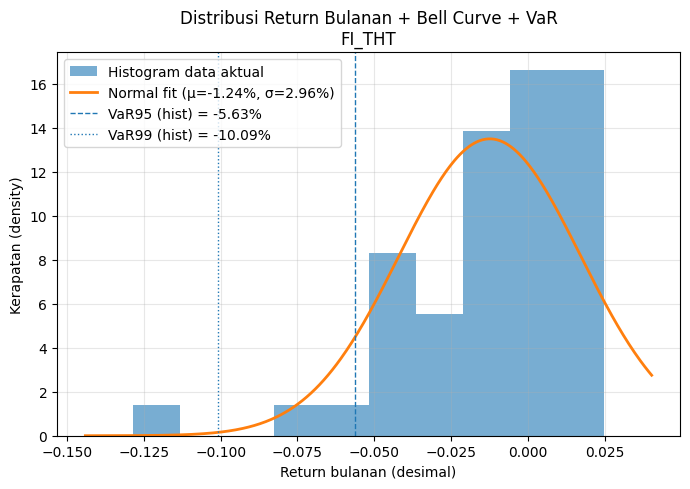


=== RD_THT ===
n         : 47
Mean      : -4.6296%
Stdev     : 4.1576%
VaR95(ret): -9.6580%
VaR99(ret): -9.8432%


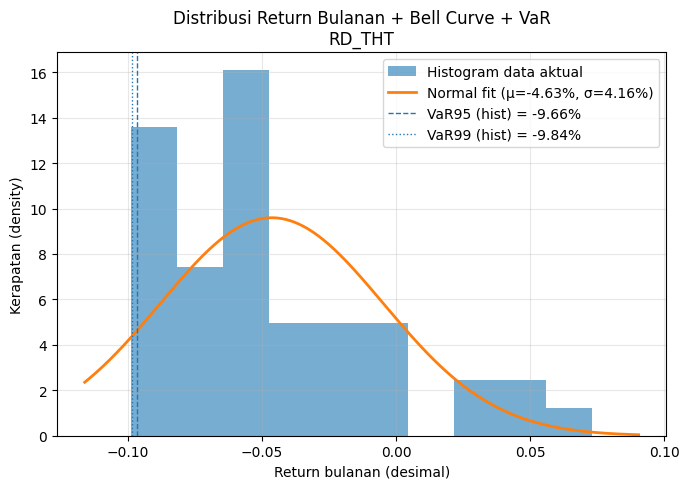


=== Saham_THT ===
n         : 35
Mean      : -18.8404%
Stdev     : 12.8077%
VaR95(ret): -29.7412%
VaR99(ret): -31.8408%


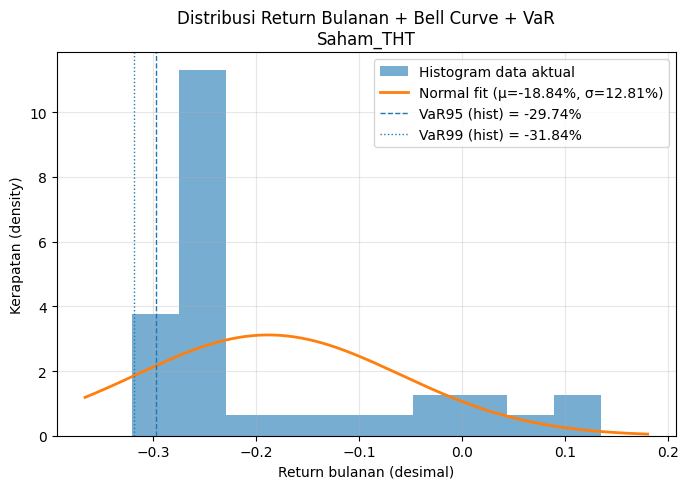

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# =========================================================
# 1. LOAD DATA
# =========================================================

file_path = "PL_asset_classes.xlsx"   # ganti jika filenya di folder lain
df = pd.read_excel(file_path)

asset_cols = ["FI_THT", "RD_THT", "Saham_THT"]

# =========================================================
# 2. LOOP PER KELAS ASET: HISTOGRAM + NORMAL FIT + GARIS VaR
# =========================================================

for col in asset_cols:
    series = df[col].dropna()
    mu = series.mean()
    sigma = series.std(ddof=1)

    # ---------- Historical VaR (berbasis data aktual) ----------
    alpha_95 = 0.95
    alpha_99 = 0.99

    # quantile kiri (return terburuk)
    q05 = series.quantile(1 - alpha_95)   # ~ 5% terburuk
    q01 = series.quantile(1 - alpha_99)   # ~ 1% terburuk

    print(f"\n=== {col} ===")
    print(f"n         : {len(series)}")
    print(f"Mean      : {mu:.4%}")
    print(f"Stdev     : {sigma:.4%}")
    print(f"VaR95(ret): {q05:.4%}")
    print(f"VaR99(ret): {q01:.4%}")

    # ---------- Sumbu X untuk normal fit ----------
    x_min = series.min()
    x_max = series.max()
    # Perlebar sedikit kiri-kanan untuk visual
    x_range = x_max - x_min
    x = np.linspace(x_min - 0.1 * x_range, x_max + 0.1 * x_range, 400)
    y = norm.pdf(x, mu, sigma)

    # ---------- Plot ----------
    plt.figure(figsize=(7, 5))

    # 1) Histogram data aktual (density=True supaya area = 1)
    plt.hist(series,
             bins=10,
             density=True,
             alpha=0.6,           # agak transparan
             label="Histogram data aktual")

    # 2) Kurva normal fit
    plt.plot(x, y, linewidth=2, label=f"Normal fit (μ={mu:.2%}, σ={sigma:.2%})")

    # 3) Garis vertikal VaR (historical)
    plt.axvline(q05, linestyle="--", linewidth=1, label=f"VaR95 (hist) = {q05:.2%}")
    plt.axvline(q01, linestyle=":",  linewidth=1, label=f"VaR99 (hist) = {q01:.2%}")

    # ---------- Layout ----------
    plt.title(f"Distribusi Return Bulanan + Bell Curve + VaR\n{col}")
    plt.xlabel("Return bulanan (desimal)")
    plt.ylabel("Kerapatan (density)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()